In [39]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from torchvision import datasets
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F

In [40]:
num_workers = 2
batch_size = 64
transform = transforms.ToTensor()
train_data = datasets.MNIST(root='data', train=True,download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,num_workers=num_workers)

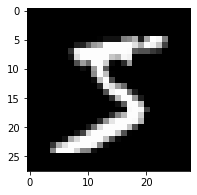

In [41]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

img = np.squeeze(images[0])

fig = plt.figure(figsize = (3,3)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray');

In [42]:
class Generator(nn.Module):
    def __init__(self, latent_vector_size, hidden_size, img_size):
        super(Generator, self).__init__()

        self.fc1 = nn.Linear(in_features=latent_vector_size,out_features=hidden_size)
        self.fc2 = nn.Linear(in_features=hidden_size,out_features=hidden_size*2)
        self.fc3 = nn.Linear(in_features=hidden_size*2,out_features=hidden_size*4)

        self.fc4 = nn.Linear(in_features=4*hidden_size,out_features=img_size)
        self.dropout = nn.Dropout(p=0.3)

    def forward(self, x):
        x = F.leaky_relu(input=self.fc1(x),negative_slope=0.2)
        x = self.dropout(x)
        x = F.leaky_relu(input=self.fc2(x),negative_slope=0.2)
        x = self.dropout(x)
        x = F.leaky_relu(input=self.fc3(x),negative_slope=0.2)
        x = self.dropout(x)
        out = torch.tanh(input=self.fc4(x))
        return out

In [43]:
class Discriminator(nn.Module):
    def __init__(self, img_size, hidden_size):
        super(Discriminator, self).__init__()

        self.fc1 = nn.Linear(in_features=img_size,out_features=4*hidden_size)
        self.fc2 = nn.Linear(in_features=4*hidden_size,out_features=hidden_size*2)
        self.fc3 = nn.Linear(in_features=hidden_size*2,out_features=hidden_size)

        self.fc4 = nn.Linear(in_features=hidden_size,out_features=1)
        self.dropout = nn.Dropout(p=0.3)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = F.leaky_relu(input=self.fc1(x),negative_slope=0.2)
        x = self.dropout(x)
        x = F.leaky_relu(input=self.fc2(x),negative_slope=0.2)
        x = self.dropout(x)
        x = F.leaky_relu(input=self.fc3(x),negative_slope=0.2)
        x = self.dropout(x)
        out = torch.sigmoid(input=self.fc4(x))
        return out

In [44]:
img_size = 784
hidden_size = 32
latent_vector_size = 100

In [45]:
G = Generator(latent_vector_size, hidden_size, img_size)
D = Discriminator(img_size, hidden_size)
print(G)
print(D)

Generator(
  (fc1): Linear(in_features=100, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=784, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)
Discriminator(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)


In [46]:
def real_loss(D_out, smooth=False):
    batch_size = D_out.size(0)
    if smooth:
        labels = torch.ones(batch_size) * 0.9
    else:
        labels = torch.ones(batch_size)

    criterion = nn.BCELoss()
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size)
    criterion = nn.BCELoss()
    loss = criterion(D_out.squeeze(), labels)
    return loss

In [47]:
import torch.optim as optim
lr = 0.002
d_optimizer = optim.Adam(D.parameters(), lr)
g_optimizer = optim.Adam(G.parameters(), lr)

In [48]:
import pickle as pkl

num_epochs = 50

samples = []
losses = []

print_every = 400

# Get some fixed data for sampling. These are images that are held
# constant throughout training, and allow us to inspect the model's performance
sample_size=16
fixed_z = np.random.uniform(-1, 1, size=(sample_size, latent_vector_size))
fixed_z = torch.from_numpy(fixed_z).float()

D.train()
G.train()
for epoch in range(num_epochs):    
    for batch_i, (real_images, _) in enumerate(train_loader):
        batch_size = real_images.size(0)
        real_images = real_images*2 - 1

        # Training Discriminator
        d_optimizer.zero_grad()
        D_real = D(real_images)
        d_real_loss = real_loss(D_real, smooth=True)

        with torch.no_grad():
            z = np.random.uniform(-1, 1, size=(batch_size, latent_vector_size))
            z = torch.from_numpy(z).float()
            fake_images = G(z)
        D_fake = D(fake_images)
        d_fake_loss = fake_loss(D_fake)
        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        d_optimizer.step()
        
        # Training Generator
        g_optimizer.zero_grad()
        z = np.random.uniform(-1, 1, size=(batch_size, latent_vector_size))
        z = torch.from_numpy(z).float()
        fake_images = G(z)
        D_fake = D(fake_images)
        g_loss = real_loss(D_fake)
        g_loss.backward()
        g_optimizer.step()

        if batch_i % print_every == 0:
            print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                    epoch+1, num_epochs, d_loss.item(), g_loss.item()))

    losses.append((d_loss.item(), g_loss.item()))

    # generate and save sample, fake images
    G.eval()
    samples_z = G(fixed_z)
    samples.append(samples_z)
    G.train()


# Save training generator samples
with open('train_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)

Epoch [    1/   50] | d_loss: 1.3911 | g_loss: 0.7752
Epoch [    1/   50] | d_loss: 1.4263 | g_loss: 0.6726
Epoch [    1/   50] | d_loss: 1.1026 | g_loss: 2.7180
Epoch [    2/   50] | d_loss: 1.1099 | g_loss: 1.7550
Epoch [    2/   50] | d_loss: 0.9676 | g_loss: 1.9846
Epoch [    2/   50] | d_loss: 1.0527 | g_loss: 1.8261
Epoch [    3/   50] | d_loss: 1.1040 | g_loss: 3.1445
Epoch [    3/   50] | d_loss: 0.6985 | g_loss: 3.5259
Epoch [    3/   50] | d_loss: 0.8948 | g_loss: 1.5959
Epoch [    4/   50] | d_loss: 1.0038 | g_loss: 2.1925
Epoch [    4/   50] | d_loss: 1.2252 | g_loss: 1.0156
Epoch [    4/   50] | d_loss: 1.0284 | g_loss: 1.3664
Epoch [    5/   50] | d_loss: 1.1404 | g_loss: 1.2243
Epoch [    5/   50] | d_loss: 1.0176 | g_loss: 2.8334
Epoch [    5/   50] | d_loss: 1.3158 | g_loss: 0.9625
Epoch [    6/   50] | d_loss: 1.0479 | g_loss: 2.6739
Epoch [    6/   50] | d_loss: 1.1164 | g_loss: 1.1222
Epoch [    6/   50] | d_loss: 1.2040 | g_loss: 1.1290
Epoch [    7/   50] | d_loss

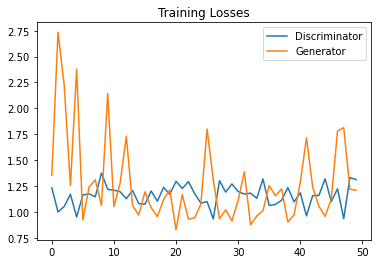

In [49]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()

In [50]:
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach()
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')

In [51]:
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

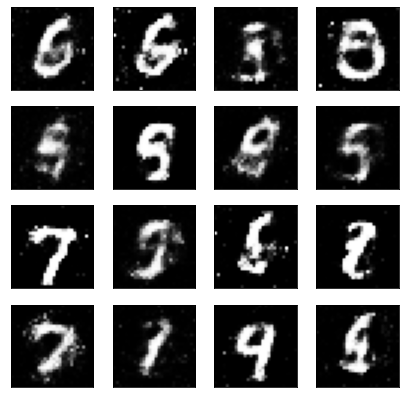

In [52]:
# -1 indicates final epoch's samples (the last in the list)
view_samples(-1, samples)

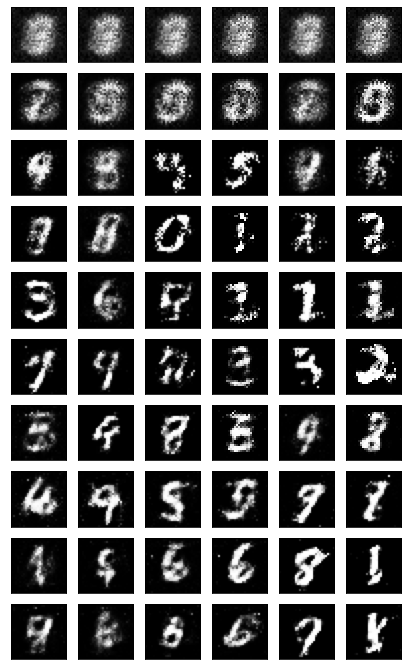

In [53]:
rows = 10 # split epochs into 10, so 100/10 = every 10 epochs
cols = 6
fig, axes = plt.subplots(figsize=(7,12), nrows=rows, ncols=cols, sharex=True, sharey=True)

for sample, ax_row in zip(samples[::int(len(samples)/rows)], axes):
    for img, ax in zip(sample[::int(len(sample)/cols)], ax_row):
        img = img.detach()
        ax.imshow(img.reshape((28,28)), cmap='Greys_r')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

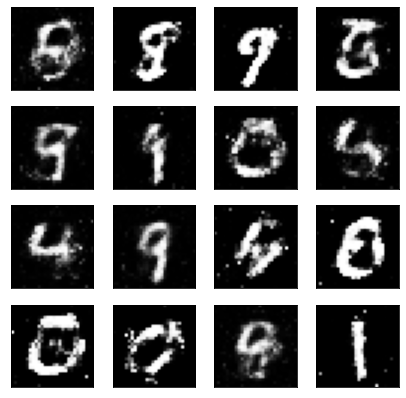

In [54]:
# randomly generated, new latent vectors
sample_size=16
rand_z = np.random.uniform(-1, 1, size=(sample_size, latent_vector_size))
rand_z = torch.from_numpy(rand_z).float()

G.eval() # eval mode
# generated samples
rand_images = G(rand_z)

# 0 indicates the first set of samples in the passed in list
# and we only have one batch of samples, here
view_samples(0, [rand_images])